In [1]:
import math
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from PIL import Image

<h1> Create Black and White Images </h1>

In [2]:
voxel_count_width = 100
image1 = Image.open('/Users/aloksaxena/Desktop/alok.png').convert('L').resize((voxel_count_width, voxel_count_width))
image2 = Image.open('/Users/aloksaxena/Desktop/varun.png').convert('L').resize((voxel_count_width, voxel_count_width))

black_and_white_image_1 = np.rot90((np.array(image1) < 70).astype(int), 3)
black_and_white_image_2 = np.rot90((np.array(image2) < 70).astype(int), 2)

<h1> Define cube dimensions and initialize cube matrix with trivial case </h1>

In [3]:
big_cube_side_length = 1
cube_side_length = big_cube_side_length / float(voxel_count_width)
cube_matrix = (np.random.rand(voxel_count_width, voxel_count_width, voxel_count_width) > 1.0).astype(int)
cube_matrix[:, :, 0] = black_and_white_image_1
cube_matrix[0, :, :] = black_and_white_image_2


<h1> Define position of the camera </h1>

In [4]:
distance_from_camera_to_closest_face = 2.0
focal_length = 1.0
sensor_width = 1.0

<h1> Construct image from real world coordinates of cube matrix and camera parameters </h1>

<h2> Method for achieving this in a non-vectorized fashion </h2>

In [5]:
def determine_voxel_vertex_world_coordinates(voxel):
    x, y, z = voxel
    v1 = ((x - 0.5 * voxel_count_width) * cube_side_length, (y - 0.5 * voxel_count_width) * cube_side_length, z * cube_side_length + distance_from_camera_to_closest_face)
    v2 = (v1[0], v1[1] + cube_side_length, v1[2])
    v3 = (v2[0] + cube_side_length, v2[1], v2[2])
    v4 = (v3[0], v3[1] - cube_side_length, v3[2])
    v5 = (v4[0], v4[1], v4[2] + cube_side_length)
    v6 = (v5[0], v5[1] + cube_side_length, v5[2])
    v7 = (v6[0] - cube_side_length, v6[1], v6[2])
    v8 = (v7[0], v7[1] - cube_side_length, v7[2])
    return (v1, v2, v3, v4, v5, v6, v7, v8)
    
    

In [6]:
def convert_to_image_coordinate(world_coordinate):
    x_p = (world_coordinate[0] * focal_length) / (world_coordinate[2])
    y_p = (world_coordinate[1] * focal_length) / (world_coordinate[2])
    return (x_p, y_p)
    

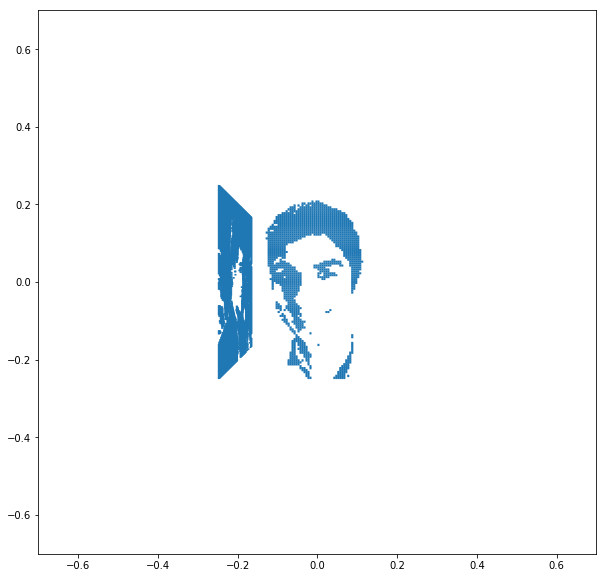

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim(-0.7, 0.7)
plt.ylim(-0.7, 0.7)
patches = []
i = 0
for x in range(voxel_count_width):
    for y in range(voxel_count_width):
        for z in range(voxel_count_width):
            if cube_matrix[x, y, z]:
                voxel = (x, y, z)
                voxel_vertex_world_coordinates = determine_voxel_vertex_world_coordinates(voxel)
                voxel_vertex_image_coordinates = tuple([convert_to_image_coordinate(world_coordinate) for world_coordinate in voxel_vertex_world_coordinates])
                convex_hull = ConvexHull(np.array(voxel_vertex_image_coordinates))
                polygon = Polygon(convex_hull.points[convex_hull.vertices], True)
                patches.append(polygon)
                i += 1

p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=1.0)
# colors = 100*np.random.rand(len(patches))
# p.set_array(np.array(colors))
ax.add_collection(p)
plt.show()  


<h1> Method for achieving this in a vectorized fashion </h1>

<h2> Get cube matrix voxel world coordinates </h2>

In [7]:
xv, yv, zv = np.meshgrid(np.arange(100), np.arange(100), np.arange(100))
cube_matrix_voxel_positions = np.stack([yv, xv, zv], axis=3)
cube_matrix_voxel_world_coordinates = np.zeros((voxel_count_width, voxel_count_width, voxel_count_width, 24))

# point 1
cube_matrix_voxel_world_coordinates[:,:,:,0] = (cube_matrix_voxel_positions[:,:,:,0] - 0.5 * voxel_count_width) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,1] = (cube_matrix_voxel_positions[:,:,:,1] - 0.5 * voxel_count_width) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,2] = (cube_matrix_voxel_positions[:,:,:,2] - 0.5 * voxel_count_width) * cube_side_length   

# point 2
cube_matrix_voxel_world_coordinates[:,:,:,3] = (cube_matrix_voxel_positions[:,:,:,0] - 0.5 * voxel_count_width) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,4] = (cube_matrix_voxel_positions[:,:,:,1] - 0.5 * voxel_count_width + 1) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,5] = (cube_matrix_voxel_positions[:,:,:,2] - 0.5 * voxel_count_width) * cube_side_length

# point 3
cube_matrix_voxel_world_coordinates[:,:,:,6] = (cube_matrix_voxel_positions[:,:,:,0] - 0.5 * voxel_count_width + 1) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,7] = (cube_matrix_voxel_positions[:,:,:,1] - 0.5 * voxel_count_width + 1) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,8] = (cube_matrix_voxel_positions[:,:,:,2] - 0.5 * voxel_count_width) * cube_side_length

# point 4
cube_matrix_voxel_world_coordinates[:,:,:,9] = (cube_matrix_voxel_positions[:,:,:,0] - 0.5 * voxel_count_width + 1) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,10] = (cube_matrix_voxel_positions[:,:,:,1] - 0.5 * voxel_count_width) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,11] = (cube_matrix_voxel_positions[:,:,:,2] - 0.5 * voxel_count_width) * cube_side_length

# point 5
cube_matrix_voxel_world_coordinates[:,:,:,12] = (cube_matrix_voxel_positions[:,:,:,0] - 0.5 * voxel_count_width + 1) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,13] = (cube_matrix_voxel_positions[:,:,:,1] - 0.5 * voxel_count_width) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,14] = (cube_matrix_voxel_positions[:,:,:,2] - 0.5 * voxel_count_width + 1) * cube_side_length

# point 6
cube_matrix_voxel_world_coordinates[:,:,:,15] = (cube_matrix_voxel_positions[:,:,:,0] - 0.5 * voxel_count_width + 1) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,16] = (cube_matrix_voxel_positions[:,:,:,1] - 0.5 * voxel_count_width + 1) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,17] = (cube_matrix_voxel_positions[:,:,:,2] - 0.5 * voxel_count_width + 1) * cube_side_length

# point 7
cube_matrix_voxel_world_coordinates[:,:,:,18] = (cube_matrix_voxel_positions[:,:,:,0] - 0.5 * voxel_count_width) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,19] = (cube_matrix_voxel_positions[:,:,:,1] - 0.5 * voxel_count_width + 1) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,20] = (cube_matrix_voxel_positions[:,:,:,2] - 0.5 * voxel_count_width + 1) * cube_side_length

# point 8
cube_matrix_voxel_world_coordinates[:,:,:,21] = (cube_matrix_voxel_positions[:,:,:,0] - 0.5 * voxel_count_width) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,22] = (cube_matrix_voxel_positions[:,:,:,1] - 0.5 * voxel_count_width) * cube_side_length
cube_matrix_voxel_world_coordinates[:,:,:,23] = (cube_matrix_voxel_positions[:,:,:,2] - 0.5 * voxel_count_width + 1) * cube_side_length


<h2> Transform the voxel world coordinates based on camera position and orientation </h2>

In [8]:
def generate_rotation_matrix(rotation_x_axis, rotation_y_axis, rotation_z_axis):
    R_x = np.array([[1, 0, 0],
                    [0, math.cos(rotation_x_axis), -math.sin(rotation_x_axis)],
                    [0, math.sin(rotation_x_axis), math.cos(rotation_x_axis)]])
    
    R_y = np.array([[math.cos(rotation_y_axis), 0, math.sin(rotation_y_axis)],
                    [0, 1, 0],
                    [-math.sin(rotation_y_axis), 0, math.cos(rotation_y_axis)]])
    
    R_z = np.array([[math.cos(rotation_z_axis), -math.sin(rotation_z_axis), 0],
                    [math.sin(rotation_z_axis), math.cos(rotation_z_axis), 0],
                    [0, 0, 1]])
    
    R = np.dot(np.dot(R_x, R_y), R_z)
    return R
    
    

In [25]:
camera_position = (0, 0, -1.5)
rotation_x_axis = 0
rotation_y_axis = 0
rotation_z_axis = 0

R = generate_rotation_matrix(rotation_x_axis, rotation_y_axis, rotation_z_axis)
broadcasted_R = np.broadcast_to(R.T, (100,100,100,3,3)).T
transformed_cube_matrix_voxel_world_coordinates = np.zeros((voxel_count_width, voxel_count_width, voxel_count_width, 24))
for i in range(8):
    cube_matrix_section = cube_matrix_voxel_world_coordinates[:,:,:,3*i:3*(i+1)].T[:,np.newaxis,:,:,:]
    transformed_cube_matrix_voxel_world_coordinates[:,:,:,3*i:3*(i+1)] = np.squeeze(np.einsum('abcde,bfcde->afcde', broadcasted_R, cube_matrix_section).T)
    transformed_cube_matrix_voxel_world_coordinates[:,:,:,3*i] = transformed_cube_matrix_voxel_world_coordinates[:,:,:,3*i] - camera_position[0]
    transformed_cube_matrix_voxel_world_coordinates[:,:,:,3*i+1] = transformed_cube_matrix_voxel_world_coordinates[:,:,:,3*i+1] - camera_position[1]
    transformed_cube_matrix_voxel_world_coordinates[:,:,:,3*i+2] = transformed_cube_matrix_voxel_world_coordinates[:,:,:,3*i+2] - camera_position[2]

<h2> Get voxel image coordinates </h2>

In [26]:
cube_matrix_voxel_image_coordinates = np.zeros([voxel_count_width, voxel_count_width, voxel_count_width, 16])
for i in range(8):
    cube_matrix_voxel_image_coordinates[:,:,:,2*i] = transformed_cube_matrix_voxel_world_coordinates[:,:,:,3*i] * focal_length / transformed_cube_matrix_voxel_world_coordinates[:,:,:,3*i+2]
    cube_matrix_voxel_image_coordinates[:,:,:,2*i+1] = transformed_cube_matrix_voxel_world_coordinates[:,:,:,3*i+1] * focal_length / transformed_cube_matrix_voxel_world_coordinates[:,:,:,3*i+2]
cube_matrix_voxel_image_coordinates = cube_matrix_voxel_image_coordinates.reshape(100,100,100,8,2)

In [27]:
polygons = []
for x in range(voxel_count_width):
    for y in range(voxel_count_width):
        for z in range(voxel_count_width):
            if cube_matrix[x, y, z]:
                voxel_vertex_image_coordinates = cube_matrix_voxel_image_coordinates[x,y,z,:,:]
                convex_hull = ConvexHull(voxel_vertex_image_coordinates)
                polygon = Polygon(convex_hull.points[convex_hull.vertices], True)
                polygons.append(polygon)
            

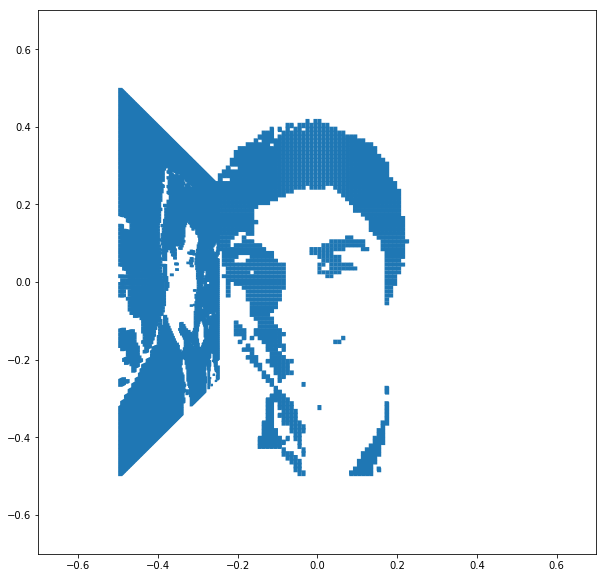

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim(-0.7, 0.7)
plt.ylim(-0.7, 0.7)

p = PatchCollection(polygons, cmap=matplotlib.cm.jet, alpha=1.0)
# p.set_array(np.array(colors))
ax.add_collection(p)
plt.show()  

<h1> Get shadow intersections </h1>

In [8]:
def cross_product(p1, p2):
    x1, x2, x3 = p1
    y1, y2, y3 = p2
    a = x1 * y2 - x2 * y1
    b = x3 * y1 - x1 * y3
    c = x2 * y3 - x3 * y2
    return (a, b, c)
    
def get_plane_defined_by_two_points_and_origin(p1, p2):
    a, b, c, = cross_product(p1, p2)
    d = 0
    plane_equation_coefficients = a, b, c, d
    return plane_equation_coefficients



In [9]:
def get_voxel_centroid_world_coordinates(voxel_count_width, cube_side_length):
    voxel_centroid_world_coordinates = np.zeros([voxel_count_width, voxel_count_width, voxel_count_width, 3])
    for i in range(voxel_count_width):
        voxel_centroid_world_coordinates[i, :, :, 0] = (i + 0.5) * cube_side_length
        voxel_centroid_world_coordinates[:, i, :, 1] = (i + 0.5) * cube_side_length
        voxel_centroid_world_coordinates[:, :, i, 2] = (i + 0.5) * cube_side_length
    return voxel_centroid_world_coordinates
    
    

In [10]:
voxel_centroid_world_coordinates = get_voxel_centroid_world_coordinates(voxel_count_width, cube_side_length)
def compute_cone_shadow(voxel):
    voxel_world_coordinates = determine_voxel_vertex_coordinates(voxel)
    voxel_world_depth = voxel_world_coordinates[2] + distance_from_camera_to_closest_face    
    convex_hull = ConvexHull(np.array(voxel_vertex_image_coordinates))
    convex_hull_world_coordinates = voxel_world_coordinates[convex_hull.vertices]
    masks = []
    for i in range(len(convex_hull_world_coordinates) - 1):
        p1, p2 = convex_hull_world_coordinates[i], convex_hull_world_coordinates[i + 1]
        a, b, c = get_plane_defined_by_two_points_and_origin(p1, p2)
        
        normal_vector = cross_product(p1, p2)
        direction = None
        if normal_vector[0] > 0:
            direction = {'dimension': 'x', 'sign': 'positive'}
        elif normal_vector[0] < 0:
            direction = {'dimension': 'x', 'sign': 'negative'}
        elif normal_vector[1] == 0:
            if normal_vector[1] > 0:
                direction = {'dimension': 'y', 'sign': 'positive'}
            if normal_vector[1] < 0:
                direction = {'dimension': 'y', 'sign': 'negative'}
                
        
        if direction['dimension'] == 'x':
            function_values = (-b/a) * voxel_centroid_world_coordinates[:, :, :, 1] + \
                              (-c/a) * voxel_centroid_world_coordinates[:, :, :, 2]            
            if direction['sign'] == 'positive':
                masks[i] = function_values >= 0
            elif direction['sign'] == 'negative':
                masks[i] = function_values <= 0

        if direction['dimension'] == 'y':
            function_values = (-a/b) * voxel_centroid_world_coordinates[:, :, :, 0] + \
                              (-c/b) * voxel_centroid_world_coordinates[:, :, :, 2]            
            if direction['sign'] == 'positive':
                masks[i] = function_values >= 0
            elif direction['sign'] == 'negative':
                masks[i] = function_values <= 0
    
    # set final_mask to intersection across all masks in list

                
        

    
    
#     for shadow_integer_depth in range(voxel_count_width - voxel[2]):
#         shadow_world_depth = voxel_world_depth + shadow_integer_depth * cube_side_length
#         shadow_left_point = voxel_world_coordinates[0] * shadow_world_depth / voxel_world_depth
#         shadow_right_point = voxel_world_coordinates[4] * shadow_world_depth / voxel_world_depth
        
        
        
        

        